In [12]:
import numpy as np
import pandas as pd
import random
import os
#from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

from federated_utils_fedavg import *

In [13]:
#declear path to your data
derbin_data_path = 'C:/Users/Ayushi Chaudhuri/Desktop/Malware 2.0/FL/drebin.csv'
malgenome_data_path = 'C:/Users/Ayushi Chaudhuri/Desktop/Malware 2.0/FL/malgenome.csv'


In [14]:
derbin_data = pd.read_csv(derbin_data_path, header = None)
malgenome_data = pd.read_csv(malgenome_data_path)

use_data  = malgenome_data

In [15]:
use_data

,transact,bindService,onServiceConnected,ServiceConnection,android.os.Binder,READ_SMS,attachInterface,WRITE_SMS,TelephonyManager.getSubscriberId,Ljava.lang.Class.getCanonicalName,...,Ljava.lang.Object.getClass,SET_ORIENTATION,DEVICE_POWER,EXPAND_STATUS_BAR,GET_TASKS,GLOBAL_SEARCH,GET_PACKAGE_SIZE,SET_PREFERRED_APPLICATIONS,android.intent.action.PACKAGE_CHANGED,class
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,S
1,0,0,0,0,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,S
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,S
3,0,0,0,0,0,1,0,1,1,0,...,1,0,0,0,0,0,0,0,0,S
4,1,1,1,1,1,1,1,1,1,1,...,1,0,1,0,0,0,0,0,0,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3794,0,1,1,1,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,B
3795,1,1,1,1,1,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,B
3796,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,B
3797,1,1,1,1,1,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,B


In [16]:
X = np.array(use_data.iloc[:,range(0,215)]) #feature set
labels = use_data.iloc[:,-1] #labels --> B : Benign and S

In [17]:
#binarize the labels
lb = LabelBinarizer()
y = lb.fit_transform(labels)

In [18]:
#split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=100)

In [19]:
number_of_clients = 5
comms_round = 10

In [20]:
#create clients -- Horizontal FL
clients = create_clients(X_train, y_train, num_clients=number_of_clients, initial='client')

#process and batch the training data for each client
clients_batched = dict()
for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data)

In [21]:
#process and batch the test set  
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

In [22]:
#==============================================
# Traditional FedAvg 2017
#==============================================
#-----------------------------------------------


all_results=list()

#create optimizer
lr = 0.01 
loss='binary_crossentropy'
metrics = ['accuracy']
optimizer = SGD(learning_rate=lr, 
                decay=lr / comms_round, 
                momentum=0.9
               )

#initialize global model
smlp_global = SimpleMLP()
global_model = smlp_global.build(X.shape[1],1)
#-----------------------------------------------


print('|=======================|')
print('|Traditional FedAvg 2017|')
print('|=======================|')

#commence global training loop
for comm_round in range(comms_round):
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #randomize client data - using keys
    client_names= list(clients_batched.keys())
    random.shuffle(client_names)
    
    #loop through each client and create new local model
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(X.shape[1],1)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(clients_batched[client], epochs=32, verbose=0)
        
        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)

    #test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
        all_results.append([global_acc,global_loss.numpy()])
        

|=======================|
|Traditional FedAvg 2017|
|=======================|
24/24 [==============================] - 0s 1ms/step
comm_round: 0 | global_acc: 98.816% | global_loss: 0.572604775428772
24/24 [==============================] - 0s 2ms/step
comm_round: 1 | global_acc: 99.211% | global_loss: 0.5703935027122498
24/24 [==============================] - 0s 1ms/step
comm_round: 2 | global_acc: 99.211% | global_loss: 0.5696427822113037
24/24 [==============================] - 0s 1ms/step
comm_round: 3 | global_acc: 99.211% | global_loss: 0.5692779421806335
24/24 [==============================] - 0s 2ms/step
comm_round: 4 | global_acc: 99.211% | global_loss: 0.5690330266952515
24/24 [==============================] - 0s 2ms/step
comm_round: 5 | global_acc: 99.211% | global_loss: 0.5688058733940125
24/24 [==============================] - 0s 2ms/step
comm_round: 6 | global_acc: 99.342% | global_loss: 0.5686421990394592
24/24 [==============================] - 0s 1ms/step
comm_roun

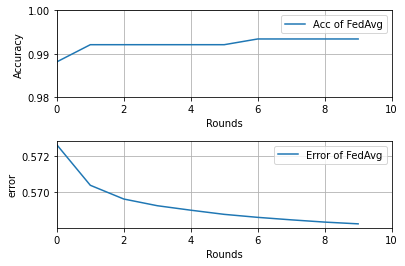

In [27]:
import numpy as np
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1)
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.5)

s1 = np.array(all_results) #FedAvg

t = range(0,s1.shape[0])

ax1.plot(t, s1[:,0],label='Acc of FedAvg')
ax1.set_xlim(0,s1.shape[0])
ax1.set_xlabel('Rounds')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0.98,1)
ax1.grid(True)
ax1.legend()


ax2.plot(t, s1[:,1],label='Error of FedAvg')
ax2.set_xlim(0, s1.shape[0])
ax2.set_xlabel('Rounds')
ax2.set_ylabel('error')
ax2.grid(True)
ax2.legend()

plt.show()



In [26]:
s1.shape

(10, 2)